In [ ]:
your_path = "/content/"
try:
    from google.colab import drive
    drive.mount('/content/drive')
    import os
    os.chdir(your_path)
    print(os.getcwd())
except ModuleNotFoundError:
    print("you are not in google colab, pass this phase")
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

Mounted at /content/drive
/content


# Convolutional Neural Network

## Manual Kernel

수직과 수평커널을 만들어서 어떤 효과가 있는지 살펴본다.

In [ ]:
k = torch.FloatTensor([[1, 0, -1], 
                       [1, 0, -1], 
                       [1, 0 , -1]])
k.size()

torch.Size([3, 3])

In [ ]:
k= torch.FloatTensor([[1, 0, -1], 
                     [1, 0, -1], 
                     [1, 0, -1]]).unsqueeze(0)
print(k.size())
print(k)

torch.Size([1, 3, 3])
tensor([[[ 1.,  0., -1.],
         [ 1.,  0., -1.],
         [ 1.,  0., -1.]]])


In [ ]:
k= torch.FloatTensor([[1, 0, -1], 
                    [1, 0, -1], 
                    [1, 0, -1]]).unsqueeze(0).unsqueeze(0)
print(k.size())
print(k)

torch.Size([1, 1, 3, 3])
tensor([[[[ 1.,  0., -1.],
          [ 1.,  0., -1.],
          [ 1.,  0., -1.]]]])


In [ ]:
k= torch.FloatTensor([[1, 0, -1], 
                       [1, 0, -1], 
                       [1, 0, -1]]).unsqueeze(0).repeat(3, 1, 1).unsqueeze(0)
print(k.size())
print(k)

torch.Size([1, 3, 3, 3])
tensor([[[[ 1.,  0., -1.],
          [ 1.,  0., -1.],
          [ 1.,  0., -1.]],

         [[ 1.,  0., -1.],
          [ 1.,  0., -1.],
          [ 1.,  0., -1.]],

         [[ 1.,  0., -1.],
          [ 1.,  0., -1.],
          [ 1.,  0., -1.]]]])


In [ ]:
def plot_maps(outputs, titles):
    fig, axes = plt.subplots(1, len(outputs), figsize=(12, 8), dpi=100)
    for (ax, o, t) in zip(axes, outputs, titles):
        ax.imshow(o.squeeze(), cmap="bone")
        ax.axis("off")
        ax.set_title(t, fontsize=12)


In [ ]:
img = Image.open("/content/drive/MyDrive/ClassRoom/sesac인공지능/data/budapest.jpg")

In [ ]:
np.array(img).shape # array shape

(853, 1280, 3)

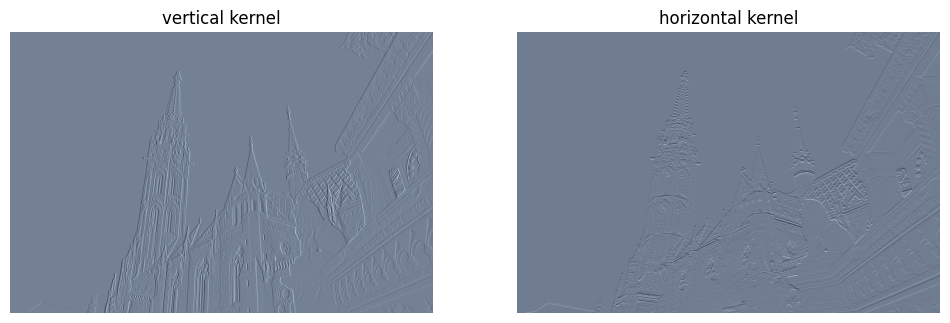

In [ ]:

# (B, C_in, H_in, W_out) \ (1, 3, 853, 1280)
img_tensor = torch.FloatTensor(np.array(img)).permute(2, 0, 1).unsqueeze(0)
# img_tensor = torch.FloatTensor(np.array(img)).transpose(2, 0, 1).unsqueeze(0)
#print(img_tensor.size())
# vertical_kernel: (C_out, C_in, K_H, K_W) = (1, 3, 3, 3)
v_kernel = torch.FloatTensor([[1, 0, -1], 
                              [1, 0, -1], 
                              [1, 0, -1]]).unsqueeze(0).repeat(3, 1, 1).unsqueeze(0)

# horizontal_kernel: (C_out, C_in, K_H, K_W)  = (1, 3, 3, 3)
h_kernel = torch.FloatTensor([[ 1,  1,  1], 
                              [ 0,  0,  0], 
                              [-1, -1, -1]]).unsqueeze(0).repeat(3, 1, 1).unsqueeze(0)

v_output = torch.nn.functional.conv2d(img_tensor, weight=v_kernel, bias=None)
h_output = torch.nn.functional.conv2d(img_tensor, weight=h_kernel, bias=None)

outputs = [v_output, h_output]
titles = ["vertical kernel", "horizontal kernel"]
# Plotting Maps
plot_maps(outputs, titles)

## Layers

### Convolution Layer

[`nn.Conv2d`](https://pytorch.org/docs/stable/nn.html#conv2d) 합성곱 연산층은 다음과 같은 arguments를 받는다.

* `in_channels`: 입력 채널 갯수
* `out_channels`: 출력 채널 갯수
* `kernel_size`: 커널(필터) 크기, integer 를 넣으면 자동으로 높이와 너비가 같은 크기의 커널이 된다. tuple에 따로 크기를 지정해서 줄 수도 있다.
* `stride`: 슬라이딩 되는 칸 수를 조정한다.
* `padding`: 패딩의 수

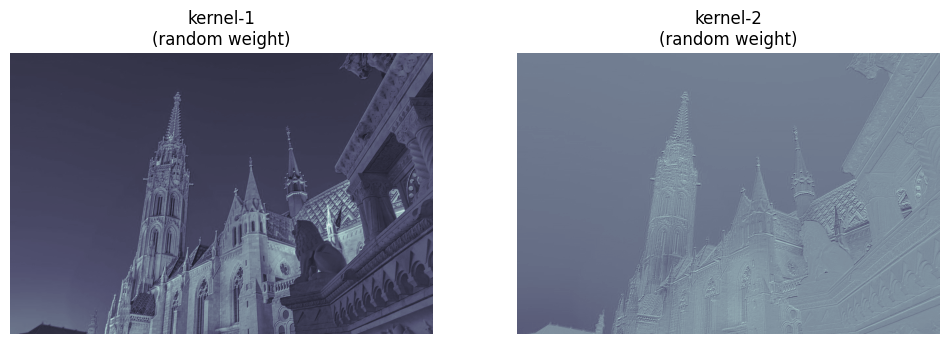

In [ ]:
seed = 777
torch.manual_seed(seed)
conv_layer = nn.Conv2d(in_channels=3, 
                       out_channels=2, 
                       kernel_size=(3, 3), 
                       stride=1,
                       padding=0)
outputs = conv_layer(img_tensor).detach()
titles = ["kernel-1\n(random weight)", "kernel-2\n(random weight)"]
# Plotting Maps
plot_maps(outputs.squeeze(), titles)

### Activation Maps

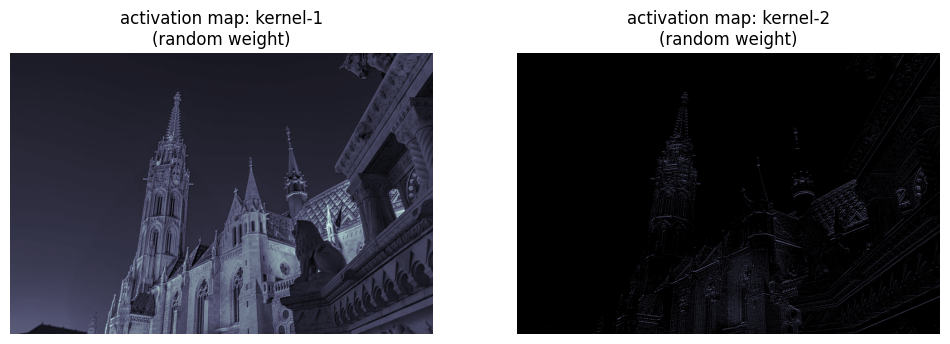

In [ ]:
activation_maps = torch.relu(outputs)
titles = ["activation map: kernel-1\n(random weight)", 
          "activation map: kernel-2\n(random weight)"]
# Plotting Maps
plot_maps(activation_maps.squeeze(), titles)

### Maxpooling Layer

[`nn.MaxPool2d`](https://pytorch.org/docs/stable/nn.html#maxpool2d) 최대 풀링층에 필요한 arguments는 다음과 같다.

* `kernel_size`: 커널(필터) 크기
* `stride`: None 값이며, 보통 커널 크기와 같게 설정된다. 
* `return_indices`: Max Pooling 한 위치를 반환한다.

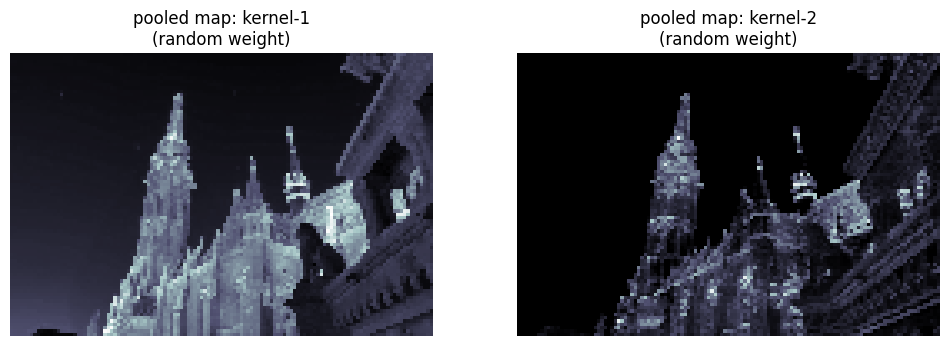

In [ ]:
maxpool_layer = nn.MaxPool2d(kernel_size=10)
pooled_maps = maxpool_layer(activation_maps)
titles = ["pooled map: kernel-1\n(random weight)", 
          "pooled map: kernel-2\n(random weight)"]
# Plotting Maps
plot_maps(pooled_maps.squeeze(), titles)

# CIFAR10 데이터 학습 시키기

Cifar 10은 각 이미지에 대해 10개의 클래스를 분류하는 데이터셋이며, 각 이미지는 (32x32) 크기를 가진 RGB 이미지다.

## 데이터 불러오기 및 전처리 파이프라인

파이프라인은 한 데이터 처리 단계의 출력이 다음 단계의 입력으로 이어지는 형태로 연결된 구조를 가리킨다. 이미지 전처리 파이프라인은 `torchvision` 패키지의 `transforms`를 주로 사용한다.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [ ]:
cifar10_mean = (0.4914, 0.4822, 0.4465)
cifar10_std = (0.2470, 0.2435, 0.2616)

img_transformer = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # 랜덤으로(0.5의 확률) 수평 대칭 뒤집기
    transforms.ToTensor(),  # Tensor로 변환 (32, 32, 3) > (3, 32, 32)
    transforms.Normalize(mean=cifar10_mean, std=cifar10_std)  # 평균과 분산으로 normalizing
])

topil = transforms.ToPILImage()
img_transformed = img_transformer(img)

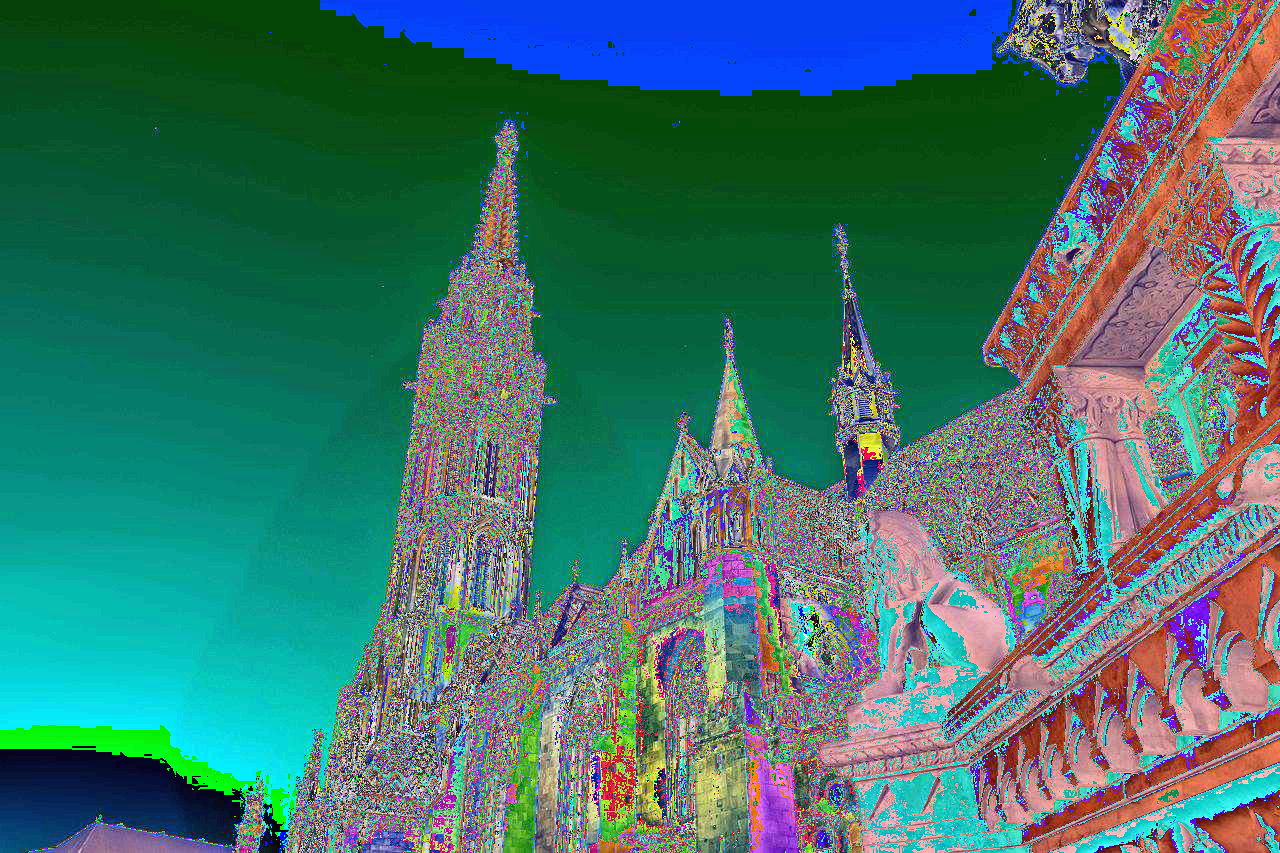

In [ ]:
topil(img_transformed)

In [ ]:
# 데이터 경로
data_path = "./"

train_dataset = datasets.CIFAR10(
    root=data_path,
    train=True, 
    transform=img_transformer,
    download=True)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=64, 
    shuffle=True)

test_dataset = datasets.CIFAR10(
    root=data_path,
    train=False, 
    transform=img_transformer,
    download=True)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=64, 
    shuffle=True)

100%|██████████| 170498071/170498071 [00:03<00:00, 46751089.10it/s]


Extracting ./cifar-10-python.tar.gz to ./
Files already downloaded and verified


In [ ]:
for batch_idx, (data, target) in enumerate(train_loader):
    # 입력과 타겟 텐서에 GPU 를 사용여부 전달
#     data, target = data.to(device), target.to(device)
    break

In [ ]:
data.size()

torch.Size([64, 3, 32, 32])

## CNN 모델 (Coding Part)

### 네트워크 설계

* Input Size = (B, 3, 32, 32)
* Output Size = (B, 10)
* Activation Function(`nn.ReLU`): ReLU
* Loss Function(`nn.CrossEntropyLoss`): Cross Entropy Loss
* Optimizer(`optim.Adam`): Adam
* Convolutional Layer: `self.convs` 변수의 `nn.Sequential`안에 구현
    > Conv1
    > 
    > 1. Conv(`nn.Conv2d`): 입력채널 3, 출력채널 8, 커널크기 3, 스트라이드 1, 패딩 1
    > 2. ReLU(`nn.ReLU`)
    > 3. MaxPool(`nn.MaxPool2d`): 커널크기 2
    > 
    > Conv2
    > 4. Conv(`nn.Conv2d`): 입력채널 8, 출력채널 16, 커널크기 3, 스트라이드 1, 패딩 0
    > 5. ReLU(`nn.ReLU`)
    > 6. MaxPool(`nn.MaxPool2d`): 커널크기 2
    > 
    > Conv3
    > 7. Conv(`nn.Conv2d`): 입력채널 16, 출력채널 32, 커널크기 2, 스트라이드 1, 패딩 0
    > 8. ReLU(`nn.ReLU`)
    > 9. MaxPool(`nn.MaxPool2d`): 커널크기 2
* Fully Connected Layer: `self.fc` 변수의 `nn.Sequential`안에 구현
    > 1. Linear(`nn.Linear`): Hidden Size = 100 (**입력 뉴런수 계산 필요**)
    > 2. ReLU(`nn.ReLU`)
    > 3. Linear(`nn.Linear`): Hidden Size = 100
    > 4. ReLU(`nn.ReLU`)
    > 5. Linear(`nn.Linear`): Hidden Size = 10

In [ ]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        # 층을 구성
        self.convs = nn.Sequential(
            # Conv1
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, stride=1, padding=1),
            #(B, 3, 32, 32) > (B, 8, 32, 32)
            nn.ReLU(),
            # (B, 8, 32, 32)
            nn.MaxPool2d(kernel_size=2, stride=2),
            # (B, 8, 16, 16)
        
            # Conv2
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=0),
            # (B, 8, 16, 16) > (B, 16, 14, 14)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # (B, 16, 14, 14) > (B, 16, 7, 7)
        
            # Conv3
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=2, stride=1, padding=0),
            # (7+0-2)/1 + 1
            # (B, 16, 7, 7) > (B, 32, 6, 6)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # (B, 32, 3, 3)
        )
        # print(nn.size())
        self.fc = nn.Sequential( # 분류를 학습하기 위한 층
            nn.Linear(in_features=32*3*3, out_features=100),  # tensor size ?
            nn.ReLU(), #(B, 100)
            nn.Linear(100, 100), #(B, 100) > (B, 100) weight(100, 100)
            nn.ReLU(),  
            nn.Linear(100, 10), 
        )
        
    def forward(self, x):
        # forward propagation 수행
        # Conv Layers
        x = self.convs(x)
        # x의 차원을 (미니배치, 32*3*3)에 알맞게 수정한다.
        x = x.view(x.size(0), -1) # --> 1차원
        # FC Layers
        x = self.fc(x)
        return x

### 손실함수 및 옵티마이저

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
# 커스텀 모듈 호출
model = Network().to(device)

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

cuda


## 모델훈련

### Train 함수(Coding Part)

In [ ]:
def train(model, train_loader, loss_function, optimizer, n_train, print_step, device):
    # Training
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # 입력과 타겟 텐서에 GPU 를 사용여부 전달
        data, target = data.to(device), target.to(device)
        # 경사 초기화
        model.zero_grad()
        # 순방향 전파. 데어터를 넣어 예측값 입력
        output = model(data)
        # 손실값 계산
        loss = loss_function(output, target)
        # 역방향 전파
        loss.backward()
        # 매개변수 업데이트
        optimizer.step()
        # 중간 과정 print
        if batch_idx % print_step == 0:
            percentage = (batch_idx*train_loader.batch_size / n_train) * 100
            print(f" - [{percentage:.2f}%] train loss: {loss:.4f}")

### Validation 함수

In [ ]:
def validation(model, test_loader, loss_function, n_test, device):
    # Validation
    model.eval()
    test_loss = 0
    correct = 0
    # torch.no_grad 를 사용하면 requires_grad 를 꺼두게 된다.
    with torch.no_grad():
        for data, target in test_loader:
            # 입력과 타겟 텐서에 GPU 를 사용여부 전달
            data, target = data.to(device), target.to(device)
            # 순방향전파
            output = model(data)
            # 손실값 계산
            test_loss += loss_function(output, target).item()
            # 예측 값에 해당하는 클래스 번호 반환
            pred = output.softmax(1).argmax(dim=1, keepdim=True)
            # 정확하게 예측한 개수를 기록한다
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_accuracy = correct / n_test
    
    return test_loss, test_accuracy

### 훈련시작

In [ ]:
n_train = len(train_dataset)
n_test = len(test_dataset)
n_step = 20
print_step = 300
best_accuracy = 0

for step in range(n_step):
    print(f"[Step] {step+1}/{n_step}\n [Training Step]")
    train(model, train_loader, loss_function, optimizer, n_train, print_step, device)
    test_loss, test_accuracy = validation(model, test_loader, loss_function, n_test, device)
    print(f" [Validation Step]")
    print(f" - test loss: {test_loss:.4f} test accuracy: {test_accuracy*100:.2f} %")
    # 제일 성능을 보인 좋은 모델 저장하기
    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        torch.save(model.state_dict(), "best_model-cifar10.pt")

[Step] 1/20
 [Training Step]
 - [0.00%] train loss: 2.3021
 - [38.40%] train loss: 1.6042
 - [76.80%] train loss: 1.3932
 [Validation Step]
 - test loss: 225.8311 test accuracy: 46.73 %
[Step] 2/20
 [Training Step]
 - [0.00%] train loss: 1.3088
 - [38.40%] train loss: 1.4571
 - [76.80%] train loss: 1.2833
 [Validation Step]
 - test loss: 204.7113 test accuracy: 53.04 %
[Step] 3/20
 [Training Step]
 - [0.00%] train loss: 1.2651
 - [38.40%] train loss: 1.1695
 - [76.80%] train loss: 1.1612
 [Validation Step]
 - test loss: 183.2544 test accuracy: 58.25 %
[Step] 4/20
 [Training Step]
 - [0.00%] train loss: 0.9660
 - [38.40%] train loss: 0.9309
 - [76.80%] train loss: 1.3711
 [Validation Step]
 - test loss: 174.9745 test accuracy: 60.47 %
[Step] 5/20
 [Training Step]
 - [0.00%] train loss: 1.3215
 - [38.40%] train loss: 0.9829
 - [76.80%] train loss: 1.4649
 [Validation Step]
 - test loss: 166.3302 test accuracy: 62.85 %
[Step] 6/20
 [Training Step]
 - [0.00%] train loss: 0.9698
 - [38.40%]

## 성능 향상시키기

Batch Normalization 을 넣어서 성능을 향상시켜보자. CNN에서 Batch Normalization 은 채널을 기준으로 Normalization 하게 된다.

In [ ]:
class NetworkBN(nn.Module):
    def __init__(self):
        super(NetworkBN, self).__init__()
        # 층을 구성
        self.convs = nn.Sequential(
            # Conv1
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(8),
            #(B, 3, 32, 32) > (B, 8, 32, 32)
            nn.ReLU(),
            # (B, 8, 32, 32)
            nn.MaxPool2d(kernel_size=2, stride=2),
            # (B, 8, 16, 16)
        
            # Conv2
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(16),
            # (B, 8, 16, 16) > (B, 16, 14, 14)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # (B, 16, 14, 14) > (B, 16, 7, 7)
        
            # Conv3
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=2, stride=1, padding=0),
            nn.BatchNorm2d(32),
            # (7+0-2)/1 + 1
            # (B, 16, 7, 7) > (B, 32, 6, 6)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # (B, 32, 3, 3)
        )
        # print(nn.size())
        self.fc = nn.Sequential(
            nn.Linear(in_features=32*3*3, out_features=100),  # tensor size ?
            nn.ReLU(), #(B, 100)
            nn.Linear(100, 100), #(B, 100) > (B, 100) weight(100, 100)
            nn.ReLU(),  
            nn.Linear(100, 10), 
        )

      
        
    def forward(self, x):
        # forward propagation 수행
        # Conv Layers
        x = self.convs(x)
        # x의 차원을 (미니배치, 32*32)에 알맞게 수정한다.
        x = x.view(x.size(0), -1)
        # FC Layers
        x = self.fc(x)
        return x

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
# 커스텀 모듈 호출
model = NetworkBN().to(device)

# loss_function = 
# optimizer = 
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


n_train = len(train_dataset)
n_test = len(test_dataset)
n_step = 20
print_step = 300
best_accuracy = 0

for step in range(n_step):
    print(f"[Step] {step+1}/{n_step}\n [Training Step]")
    # train(model, train_loader, loss_function, n_train, print_step, device)
    train(model, train_loader, loss_function, optimizer, n_train, print_step, device)
    test_loss, test_accuracy = validation(model, test_loader, loss_function, n_test, device)
    print(f" [Validation Step]")
    print(f" - test loss: {test_loss:.4f} test accuracy: {test_accuracy*100:.2f} %")
    # 제일 성능을 보인 좋은 모델 저장하기
    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        torch.save(model.state_dict(), "best_model-cifar10-bn.pt")

cuda
[Step] 1/20
 [Training Step]
 - [0.00%] train loss: 2.3267
 - [38.40%] train loss: 1.3989
 - [76.80%] train loss: 1.2660
 [Validation Step]
 - test loss: 186.5502 test accuracy: 56.57 %
[Step] 2/20
 [Training Step]
 - [0.00%] train loss: 1.3387
 - [38.40%] train loss: 1.3720
 - [76.80%] train loss: 1.1525
 [Validation Step]
 - test loss: 174.0206 test accuracy: 60.47 %
[Step] 3/20
 [Training Step]
 - [0.00%] train loss: 1.0081
 - [38.40%] train loss: 0.9483
 - [76.80%] train loss: 1.0565
 [Validation Step]
 - test loss: 162.3371 test accuracy: 63.04 %
[Step] 4/20
 [Training Step]
 - [0.00%] train loss: 1.0824
 - [38.40%] train loss: 1.0182
 - [76.80%] train loss: 0.9684
 [Validation Step]
 - test loss: 145.3918 test accuracy: 67.16 %
[Step] 5/20
 [Training Step]
 - [0.00%] train loss: 1.0201
 - [38.40%] train loss: 0.7604
 - [76.80%] train loss: 0.9046
 [Validation Step]
 - test loss: 141.3253 test accuracy: 68.24 %
[Step] 6/20
 [Training Step]
 - [0.00%] train loss: 0.9027
 - [38